In [37]:
import pandas as pd
import numpy as np
training = pd.read_excel('training.xlsx')
scoring = pd.read_excel("scoring.xlsx")


In [38]:
training.shape

(41053, 10)

In [39]:
scoring.shape

(7546, 10)

In [40]:
training = training.rename(columns={'Date': 'year'})
training = training.rename(columns={'Vehicle Category': 'vehicleCategory'})
training = training.rename(columns={'GVWR Class': 'gvwrClass'})
training = training.rename(columns={'Fuel Type': 'fuelType'})
training = training.rename(columns={"Model Year": "modelYear"})
training = training.rename(columns={"Fuel Technology": "fuelTechnology"})
training = training.rename(columns={"Electric Mile Range": "electricMileRange"})
training = training.rename(columns={"Number of Vehicles Registered at the Same Address": "numVehiclesReg"})
training = training.rename(columns={"Vehicle Population:": "vehiclePopulation"})

#Using the mean as our dataset does not contain that many outliers etc.

In [41]:
# fill missing values with the mean of our modelYear column
training['modelYear'].fillna(training['modelYear'].mean(), inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_8064\2663670663.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training['modelYear'].fillna(training['modelYear'].mean(), inplace=True)


In [42]:
#Dropping the Region column
training = training.drop(columns=['Region'])

In [43]:
training["gvwrClassKN"] = training["gvwrClass"].apply(lambda x:  1 if x == "Unknown" else 0)
training["gvwrClass"] = training["gvwrClass"].replace("Unknown", -1)
training["gvwrClass"] = training["gvwrClass"].replace("Not Applicable", 0)

C:\Users\user\AppData\Local\Temp\ipykernel_8064\4157842158.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  training["gvwrClass"] = training["gvwrClass"].replace("Not Applicable", 0)


#Our GVWR Column, 
#Not applicable = 0
#Unkown isss?
#So add a column where gvwr type included (binary)

In [44]:
print(training["gvwrClass"].apply(type).value_counts())

gvwrClass
<class 'int'>    41053
Name: count, dtype: int64


In [ ]:
#electricMileRange, we are going to later on OneHotEncode this column
#fuelType, we are going to later on OneHotEncode this column
#numVehiclesReg, we are going to later on OneHotEncode this column

In [ ]:
#An option, if this doesn't give us the results we want, we can OneHotEncode this instead
training

In [59]:
training["numVehiclesReg"] = training["numVehiclesReg"].apply(lambda x:  4 if x == "≥4" else x)
training["numVehiclesRegKN"] = training["numVehiclesReg"].apply(lambda x:  1 if x == "Unknown" else 0)
training["numVehiclesReg"] = training["numVehiclesReg"].replace("Unknown", -1)
training

C:\Users\user\AppData\Local\Temp\ipykernel_8064\1776417714.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  training["numVehiclesReg"] = training["numVehiclesReg"].replace("Unknown", -1)


,year,vehicleCategory,gvwrClass,fuelType,modelYear,fuelTechnology,electricMileRange,numVehiclesReg,Vehicle Population,gvwrClassKN,fuelTypeKN,numVehiclesRegKN
0,2019,P,0,Gasoline,2020.0,ICE,Not Applicable,4,395883,0,0,0
1,2020,P,0,Gasoline,2020.0,ICE,Not Applicable,1,370954,0,0,0
2,2021,P,0,Gasoline,2020.0,ICE,Not Applicable,1,349406,0,0,0
3,2019,P,0,Gasoline,2019.0,ICE,Not Applicable,4,348475,0,0,0
4,2019,P,0,Gasoline,2018.0,ICE,Not Applicable,4,333296,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
41048,2019,B,0,Diesel,1983.0,ICE,Not Applicable,1,1,0,0,0
41049,2019,B,0,Diesel,1980.0,ICE,Not Applicable,2,1,0,0,0
41050,2019,B,0,Diesel,1978.0,ICE,Not Applicable,3,1,0,0,0
41051,2019,B,0,Diesel,1976.0,ICE,Not Applicable,2,1,0,0,0


In [57]:
print(training.dtypes)


year                    int64
vehicleCategory        object
gvwrClass               int64
fuelType               object
modelYear             float64
fuelTechnology         object
electricMileRange      object
numVehiclesReg         object
Vehicle Population      int64
gvwrClassKN             int64
fuelTypeKN              int64
dtype: object


In [48]:
print(training['vehicleCategory'].apply(type).value_counts())

vehicleCategory
<class 'str'>    41053
Name: count, dtype: int64


In [49]:
print(training['gvwrClass'].apply(type).value_counts())

gvwrClass
<class 'int'>    41053
Name: count, dtype: int64


In [50]:
print(training['fuelType'].apply(type).value_counts())

fuelType
<class 'str'>    40967
<class 'int'>       86
Name: count, dtype: int64


In [51]:
print(training['modelYear'].apply(type).value_counts())

modelYear
<class 'float'>    41053
Name: count, dtype: int64


In [60]:
print(training['numVehiclesReg'].apply(type).value_counts())

numVehiclesReg
<class 'int'>    41053
Name: count, dtype: int64


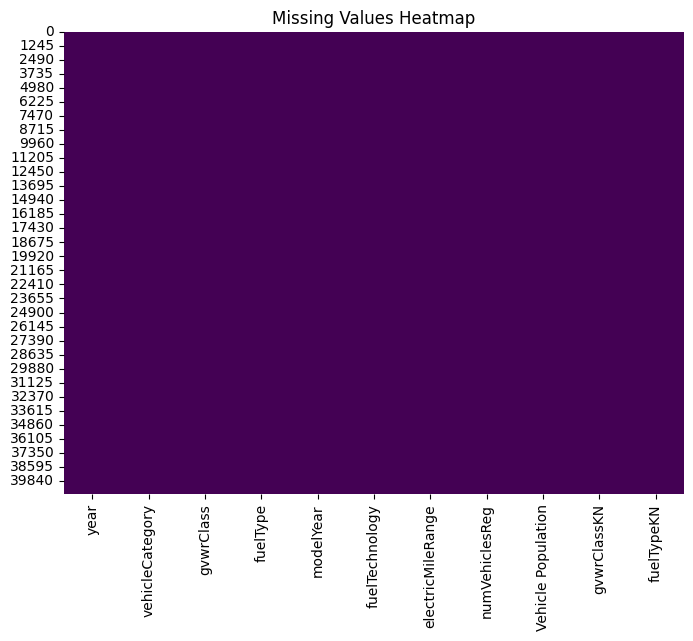

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(training.isnull(), cmap='viridis', cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

In [ ]:
training